## MNIST
- In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.
- This set has been studied so much that it is often called the “hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.
- Scikit-Learn provides many helper functions to download popular datasets.
- MNIST is one of them. The following code fetches the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
    - A **DESCR** key describing the dataset
    - A **data** key containing an array with one row per instance and one column per feature
    - A **target** key containing an array with the labels
- Let’s look at these arrays:

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- There are 70,000 images, and each image has 784 features. 
- This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). 
- Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

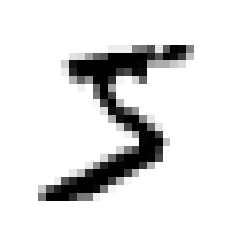

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [5]:
y[0]

'5'

In [63]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

- Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [6]:
import numpy as np
y = y.astype(np.uint8)

- You should always create a test set and set it aside before inspecting the data closely. 
- The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). 
- Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. 
- Shuffling the dataset ensures that this won’t happen.

## Training a Binary Classifier
- Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. 
- This “5-detector” will be an example of a binary classifier, **capable of distinguishing between just two classes, 5 and not-5.**
- Let’s create the target vectors for this classification task:

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

- Now let’s pick a classifier and train it. A good place to start is with a **Stochastic Gradient Descent (SGD) classifier**, using Scikit-Learn’s **SGDClassifier** class. 
- This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. 
- Let’s create an SGDClassifier and train it on the whole training set:

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## TIP
- The SGDClassifier relies on randomness during training (hence the name “stochastic”). 
- If you want reproducible results, you should set the random_state parameter.

#### Now we can use it to detect images of the number 5:

In [10]:
sgd_clf.predict([some_digit])

array([ True])

#### The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

## Performance Measures
- Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. 
- There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation

### IMPLEMENTING CROSS-VALIDATION
- Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. 
- In these cases, you can implement cross-validation yourself. 
- The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and it prints the same result:

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    # Constructs a new estimator with the same parameters. #Clone does a deep copy of the model in an estimator without actually copying attached data. It yields a new estimator with the same parameters that has not been fit on any data.
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. 
- At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold.
- Then it counts the number of correct predictions and outputs the ratio of correct predictions.

- **Let’s use the cross_val_score() function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds.** 
    - Remember that Kfold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds:

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross-validation folds? 
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # np.zeros: Return a new array of given shape and type, filled with zeros.

Can you guess this model’s accuracy? Let’s find out:

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.0997 , 0.0965 , 0.09995])

- That’s right, it has over 90% accuracy! 
- This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
- **This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).**

## Confusion Matrix
- **A much better way to evaluate the performance of a classifier** is to look at the confusion matrix. 
- The general idea is to count the number of times instances of class A are classified as class B. 
- For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.
- To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. 
- **You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).**
- Instead, you can use the **cross_val_predict()** function:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. 
- This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).
- **Now you are ready to get the confusion matrix using the confusion_matrix() function.** 
- **Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):**

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- **Each row in a confusion matrix represents an actual class, while each column represents a predicted class.**
- **The first row of this matrix considers non-5 images (the negative class): 53,057 of them were correctly classified as non-5s (they are called true negatives)**,
    -  **while the remaining 1,522 were wrongly classified as 5s (false positives).**
- **The second row considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s (false negatives),**
    - **while the remaining 4,096 were correctly classified as 5s (true positives).** 
- A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):


In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier.

- A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance.
- So precision is typically used along with another metric named **recall**, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier.

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- Now your 5-detector does not look as shiny as it did when you looked at its accuracy. 
    - When it claims an image represents a 5, it is correct only 83.7% of the time. 
    - Moreover, it only detects 65.1% of the 5s.
- It is often convenient to combine precision and recall into a single metric called the **F1 score**, in particular if you need a simple way to compare two classifiers. 
- The F1 score is the harmonic mean of precision and recall. 
- Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. 
- As a result, the classifier will only get a high F1 score if both recall and precision are high.
#### To compute the F1 score, simply call the f1_score() function:

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

- The F1 score favors classifiers that have **similar precision and recall.** 
- This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.
    - For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that **rejects many good videos (low recall)** but **keeps only safe ones (high precision)**, rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).
    - On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
- Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

### Precision/Recall Trade-off
- To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. 
- For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.
- Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. 
- Instead of calling the classifier’s predict() method, you can call its **decision_function() method**, which returns a score for each instance, **and then use any threshold** you want to make predictions based on those scores:

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- This confirms that raising the threshold decreases recall. 
- The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.
- How do you decide which threshold to use? 
    - First, use the **cross_val_predict()** function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

- With these scores, use the **precision_recall_curve()** function to compute precision and recall for all possible thresholds:

In [25]:
from sklearn.metrics import precision_recall_curve # Compute precision-recall pairs for different probability thresholds

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

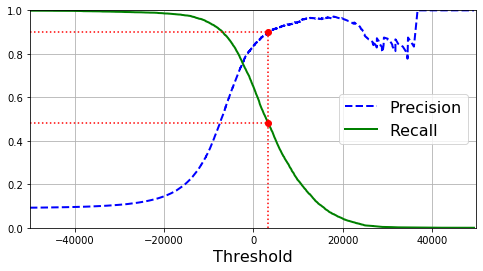

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                              
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

In [27]:
(y_train_pred == (y_scores > 0)).all()

True

- You may wonder why the precision curve is bumpier than the recall curve.
    - The reason is that **precision may sometimes go down when you raise the threshold** (although in general it will go up).
    - On the other hand, **recall can only go down when the threshold is increased**, which explains why its curve looks smooth.

#### Another way to select a good precision/recall trade-off is to plot precision directly against recall

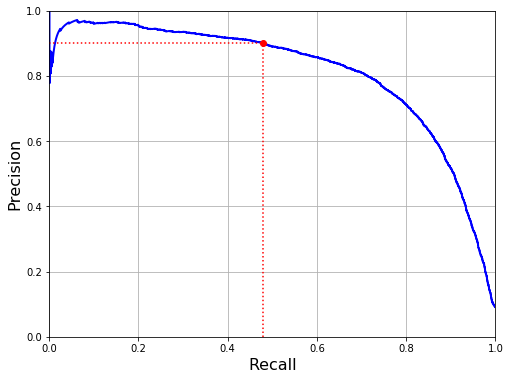

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

- You can see that precision really starts to fall sharply around 80% recall.
- **You will probably want to select a precision/recall trade-off just before that drop.** For example, at around 60% recall. But of course, the choice depends on your project.
- Suppose you decide to aim for 90% precision. 
    - You look up the first plot and find that you need to use a threshold of about 8,000. 
    - To be more precise you can search for the lowest threshold that gives you at least 90% precision (np.argmax() will give you the first index of the maximum value, which in this case means the first True value):

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

- To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [30]:
threshold_90_precision

3370.0194991439594

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let’s check these predictions’ precision and recall:

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

- Great, you have a 90% precision classifier! 
- As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. 
- But wait, not so fast. **A high-precision classifier is not very useful if its recall is too low!**

### TIP
If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

## The ROC Curve
- The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. 
- It is very similar to the precision/recall curve, but instead of plotting precision versus recall, **the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR).**
- **The FPR is the ratio of negative instances that are incorrectly classified as positive.**
- **It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative.**
- **The TNR is also called specificity. **
- Hence, the ROC curve plots **sensitivity (recall)** versus 1 – specificity.
- To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#### Then you can plot the FPR against the TPR using Matplotlib.

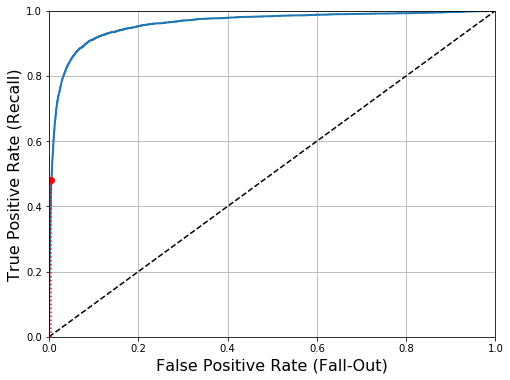

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                  
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                          

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

#### This ROC curve plots the false positive rate against the true positive rate for all possible thresholds; the red circle highlights the chosen ratio (at 43.68% recall)

- Once again there is a trade-off: **the higher the recall (TPR), the more false positives (FPR) the classifier produces.** 
- The dotted line represents the ROC curve of a purely random classifier; **a good classifier stays as far away from that line as possible (toward the top-left corner).**

- One way to compare classifiers is to measure the **area under the curve (AUC).**
- **A perfect classifier will have a ROC AUC equal to 1**, whereas a purely random classifier will have a ROC AUC equal to 0.5. 
- Scikit-Learn provides a function to compute the ROC AUC:

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### TIP
- Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. 
- As a rule of thumb, **you should prefer the PR curve whenever the positive class is rare** or when you care more about the false positives than the false negatives. 
- **Otherwise, use the ROC curve.** For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good.
- But this is mostly because there are few positives (5s) compared to the negatives (non- 5s). 
- In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

#### Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier.
- First, you need to get scores for each instance in the training set. 
- But due to the way it works, the RandomForestClassifier class does not have a decision_function() method. 
- Instead, it has a **predict_proba() method.** Scikit-Learn classifiers generally have one or the other, or both.
- The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

- **The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilities.** 
- **Let’s use the positive class’s probability as the score:**

In [38]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#### Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare

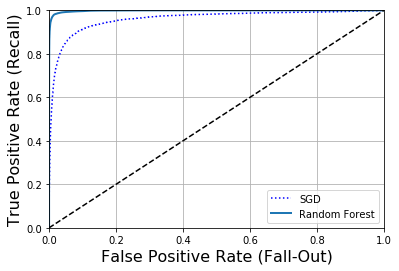

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

- Comparing ROC curves: 
    - the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC
- As you can see, **the RandomForestClassifier’s ROC curve looks much better** than the SGDClassifier’s: **it comes much closer to the top-left corner.** 
- As a result, its ROC AUC score is also significantly better:

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

#### You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. 
#### Now let’s try to detect more than just the 5s.

# Multiclass Classification
- Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.
    - Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively.
    - Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.
- One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called **the one-versus-the-rest (OvR) strategy (also called one-versus-all).**
- Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called **the one-versus-one (OvO) strategy.**
    - If there are N classes, you need to train N × (N – 1) / 2 classifiers.
    - For the MNIST problem, this means training 45 binary classifiers! 
    - When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels.
    - The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.
    - Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set.
    - **For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets.**
    - **For most binary classification algorithms, however, OvR is preferred.**
- **Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.**
- Let’s try this with a Support Vector Machine classifier, using the sklearn.svm.SVC class:

In [43]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- That was easy! This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-therest target classes (y_train_5). 
- Then it makes a prediction (a correct one in this case). 
    - Under the hood, Scikit-Learn actually used the **OvO strategy:** it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.
- If you call the **decision_function()** method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class:

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

- The highest score is indeed the one corresponding to class 5:

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

### WARNING
- **When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.** 
- In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.
## -------------------------------------------------------------------------------------------------------------------------

- If you want to force Scikit-Learn to use one-versus-one or one-versus-therest, you can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes. 
- Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). 
- For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [48]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

- Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [49]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. 
- The decision_function() method now returns one value per class. 
- Let’s look at the score that the SGD classifier assigned to each class:

In [50]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 3 has a score of 1823.73.
- Now of course you want to evaluate this classifier. As usual, you can use cross-validation. 
- Use the cross_val_score() function to evaluate the SGDClassifier’s accuracy:

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- It gets over 85% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. 
- Simply scaling the inputs increases accuracy above 89%:

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis
- If this were a real project, you would now follow the steps in your Machine Learning project checklist (see Appendix B). 
    - You’d explore data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV), and automate as much as possible. 
- Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.
- **First, look at the confusion matrix.** 
- **You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier:**

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

- That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

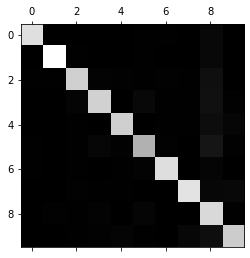

In [54]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. 
    - The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.
- Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

- Fill the diagonal with zeros to keep only the errors, and plot the result:

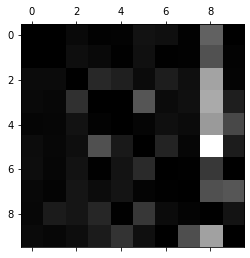

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- You can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes.
- The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. 
    - However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. 
    - You can also see that 3s and 5s often get confused (in both directions).
- Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s.
    - For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.
- Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. 

## Multilabel Classification
- Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. 
- Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. 
    - Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). 
    - Such a classification system that outputs multiple binary tags is called a multilabel classification system.
- We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes:

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

- This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. 
    - The next lines create a **KNeighborsClassifier** instance (which **supports multilabel classification**, though not all classifiers do), and we train it using the multiple targets array.
- Now you can make a prediction, and notice that **it outputs two labels:**

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

#### And it gets it right! The digit 5 is indeed not large (False) and odd (True).
- There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. - - One approach is to measure the F score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F score across all labels:

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- This assumes that all labels are equally important, however, which may not be the case. 
- In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. 
- One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). 
    - To do this, simply set average="weighted" in the preceding code.

## Multioutput Classification
- The last type of classification task we are going to discuss here is called multioutput–multiclass classification (or simply multioutput classification).
    - It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).
- To illustrate this, let’s build a system that removes noise from images. 
- It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. 
    - Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.
## ---------------------------------------------------------------------------------------------------------------------
### NOTE
The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class
labels and value labels.
## ---------------------------------------------------------------------------------------------------------------------
- Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function. The target images will be the original images:

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

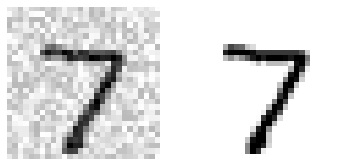

In [66]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

- On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image:

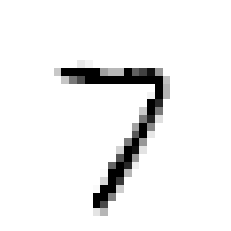

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

- Looks close enough to the target! This concludes our tour of classification. 
- You should now know how to select good metrics for classification tasks, pick the appropriate precision/recall trade-off, compare classifiers, and more generally build good classification systems for a variety of tasks.

## Exercises
1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [68]:
y_knn_pred = knn_clf.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714